# Experiments with different settings 

In [1]:
# Creating new experiment in Comet.ml
# from comet_ml import Experiment
# experiment = Experiment(
#     api_key="VCyOxE7IjP9abOTTSwvn2gfs4",
#     project_name="mri-segmentation",
#     workspace="mrugnivenko",)

# Some necessary libs
import os
import sys
import glob
import torch
import torchio
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

### Import functions from utils directory 

In [2]:
import imp

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *

import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

import utils.routine as routine
imp.reload(routine)
from utils.routine import *

import utils.metrics as metrics
imp.reload(metrics)
from utils.metrics import *

import utils.metrics_deep_mind as metrics_deep_mind
imp.reload(metrics_deep_mind)
from utils.metrics_deep_mind import *

import utils.visualization as visualization
imp.reload(visualization)
from utils.visualization import *
plot_volume = visualization.plot_volume_interactive

In [3]:
fcd_pirogov_seg_data = data_processor.DataMriSegmentation(sample = 'pirogov', prefix = 'fcd',
                         mask = 'combined', ignore_missing = True,
                         coord_min = (30,30,30, ), img_shape=(192, 192, 192, ),
                         image_path = '../datasets/fcd_classification_bank',
                         targets_path = 'targets/targets_fcd_bank.csv',
                         mask_path='../datasets/ellipse_masks')


print('\n')
print(f'Dataset size: {len(fcd_pirogov_seg_data)}')
print(f'Labels distribution: {np.unique(fcd_pirogov_seg_data.target, return_counts=True)}\n')

#Example of data 
img, seg = fcd_pirogov_seg_data[1]
print(f'Image shape: {img.shape}')
print(f'Segmentation shape: {seg.shape}')

 20%|██        | 3/15 [00:00<00:00, 20.03it/s]

Assembling data for: pirogov sample.


100%|██████████| 15/15 [00:00<00:00, 18.99it/s]




Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


In [78]:
path = '../datasets/ellipse_masks/combined/'

img_path = fcd_pirogov_seg_data.img_files[0]
seg_path = fcd_pirogov_seg_data.img_seg[0]
seg_array = load_nii_to_array(seg_path)
seg = seg_array

seg[seg < 900] = 0.0
seg[seg >= 900] = 1.0

# preparing bounding box mask 
bb_mask_path = fcd_pirogov_seg_data.img_mask[0]
mask_array = load_nii_to_array(bb_mask_path)
masked_img = mask_array

img1 = nib.load(img_path)
affine = img1.affine
# calculating combined mask as intersection of both masks
comb_mask = np.logical_and(masked_img, seg)
new_image = nib.Nifti1Image(comb_mask.astype(float), affine)
nib.save(new_image, path+img_path.split('/')[-1].split('_norm')[0]+'.nii.gz')

In [81]:
comb_mask.sum()

0

In [95]:
seg_ = load_nii_to_array(fcd_pirogov_seg_data.img_seg[0])

In [96]:
bb = load_nii_to_array(fcd_pirogov_seg_data.img_mask[0])

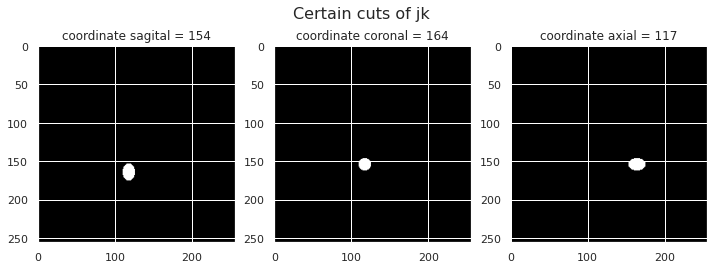

In [97]:
plot_certain_cuts(bb, get_center_coord_of_bb(bb), 'jk')

In [109]:
bb = load_nii_to_array('../datasets/fcd_classification_bank/masks/bb/fcd_0_1.nii.gz')

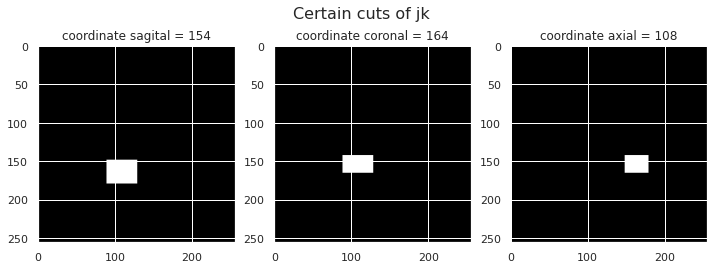

In [110]:
plot_certain_cuts(bb, get_center_coord_of_bb(bb), 'jk')

In [111]:
bb = load_nii_to_array('../datasets/fcd_classification_bank/masks/combined/fcd_0_1.nii.gz')

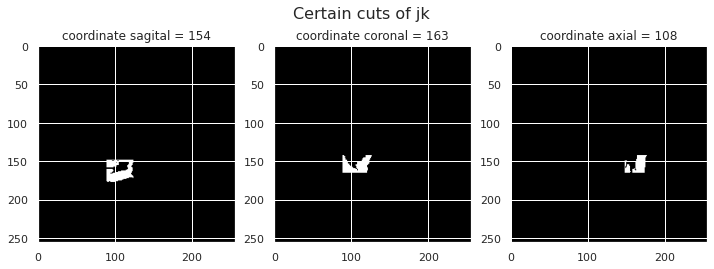

In [112]:
plot_certain_cuts(bb, get_center_coord_of_bb(bb), 'jk')

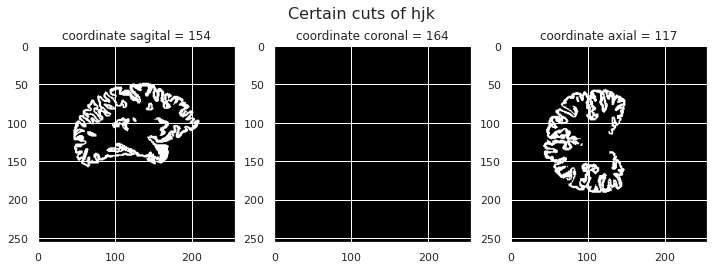

In [108]:
plot_certain_cuts(seg_, (154, 164, 117), 'hjk')

In [102]:
seg_[seg_ < 900] = 0.0
seg_[seg_ >= 900] = 1.0

In [93]:
a = np.logical_and(seg_, bb).astype(float)

In [94]:
plot_certain_cuts(a, get_center_coord_of_bb(a), 'jk')

ValueError: min() arg is an empty sequence

In [9]:
img1 = nib.load(fcd_pirogov_seg_data.img_files[0])
affine = img1.affine

In [37]:
fcd_pirogov_seg_data.img_files[0]

'../datasets/fcd_classification_bank/fcd_0_1_norm.nii.gz'

In [10]:
r = nib.Nifti1Image(a.astype(float), affine)

In [18]:
nib.save(r, '../datasets/ellipse_masks/combined/r.nii.gz')

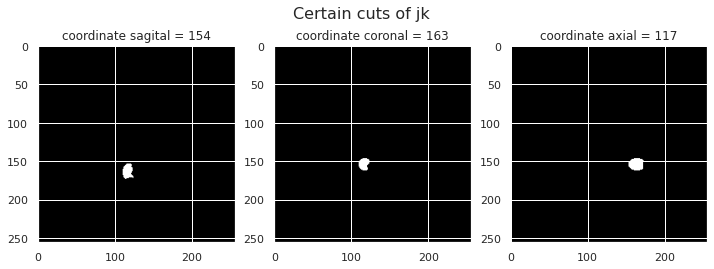

In [17]:
plot_certain_cuts(r.get_fdata(), get_center_coord_of_bb(r.get_fdata()), 'jk')

In [27]:
def create_combined_masks(data, path = '../datasets/ellipse_masks/combined/'):
    for index in range(len(data)):
        img_path = data.img_files[index]
        seg_path = data.img_seg[index]
        seg_array = load_nii_to_array(seg_path)
        seg = seg_array

        seg[seg < 900] = 0.0
        seg[seg >= 900] = 1.0

        # preparing bounding box mask 
        bb_mask_path = data.img_mask[index]
        mask_array = load_nii_to_array(bb_mask_path)
        masked_img = mask_array

        img1 = nib.load(img_path)
        affine = img1.affine
        # calculating combined mask as intersection of both masks
        comb_mask = np.logical_and(masked_img, seg)
        new_image = nib.Nifti1Image(comb_mask.astype(float), affine)
        nib.save(new_image, path+img_path.split('/')[-1].split('_norm')[0]+'.nii.gz')

In [28]:
create_combined_masks(fcd_pirogov_seg_data, path = '../datasets/ellipse_masks/combined/')

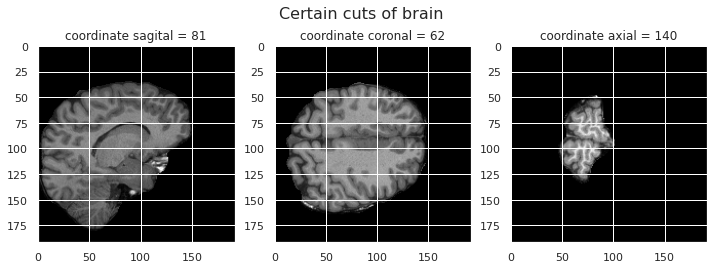

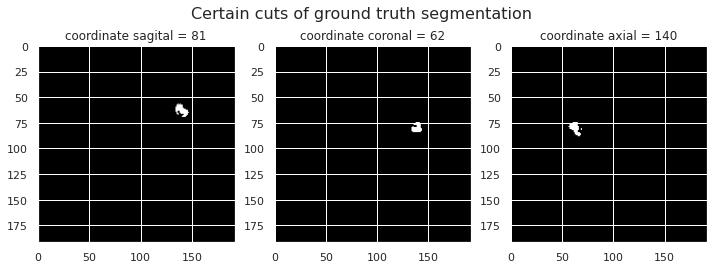

In [7]:
plot_certain_cuts(img, get_center_coord_of_bb(seg),  'brain')
plot_certain_cuts(seg, get_center_coord_of_bb(seg), 'ground truth segmentation')

In [79]:
a = load_nii_to_array('../datasets/ellipse_masks/combined/fcd_0_1.nii.gz')

In [80]:
a.sum()

0.0

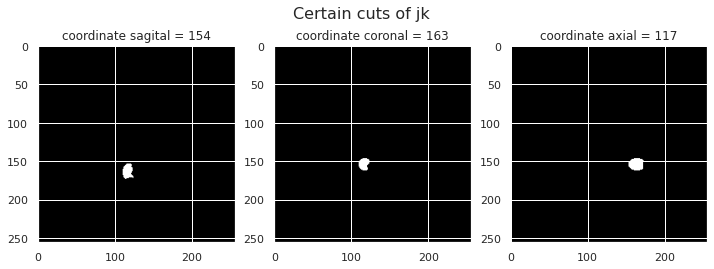

In [41]:
plot_certain_cuts(a, get_center_coord_of_bb(a), 'jk')

### Preprocessing data

In [8]:
histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy'
# for recreating landmarks remove # below 
# image_paths = list(fcd_data.img_files[train_idx].values)
# landmarks = HistogramStandardization.train(image_paths, output_path=histogram_landmarks_path)
landmarks = np.load(histogram_landmarks_path)


training_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    #RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
#     RandomFlip(axes=(0,)),
#     OneOf({
#         RandomAffine(): 0.8,
#         RandomElasticDeformation(): 0.2,
#     }),
])

validation_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
])

### Splitting data into train and test parts 

In [9]:
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_pirogov_seg_data)), y=fcd_pirogov_seg_data.target))

### Creating dataloaders for model 

In [10]:
training_loader, validation_loader = get_loaders(fcd_pirogov_seg_data, cv_splits[0],
        training_transform = training_transform,
        validation_transform = validation_transform)

Training set: 10 subjects
Validation set: 5 subjects
Mask type is combined


### Getting model and optimizer 

In [11]:
torch.cuda.empty_cache()

In [12]:
!nvidia-smi

Thu Feb 25 16:20:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   53C    P2   311W / 280W |   9965MiB / 11178MiB |     89%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   51C    P2    72W / 280W |   8879MiB / 11178MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [13]:
torch.cuda.set_device(2)

In [14]:
torch.cuda.current_device()

2

In [15]:
model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)
model.load_state_dict(torch.load('weights/all_images_augm_seg_epoch_7.pth'))

<All keys matched successfully>

In [18]:
experiment.set_name("Pirogov FCD, combined ellipse mask, dice loss")

Epoch 30 of 30 took 1466.687s
  training loss (in-iteration): 	0.974047
  validation loss: 			0.968148


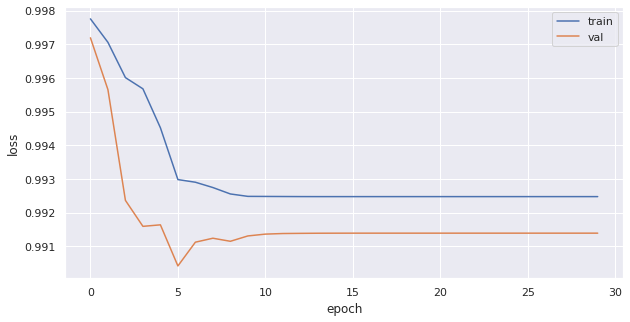

In [16]:
torch.cuda.empty_cache()

training_params =  {
    'num_epochs': 30, 
    'training_loader': training_loader, 
    'validation_loader': validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler': scheduler,
    'ratio' : False,
    'weights_stem':'pirogov_fcd_combined_ellipse_masks_dice_loss',
    'verbose':True,
    'save_epoch':1,
    'loss_type': 'dice'
}

train(**training_params)

# Results

In [24]:
model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)
model.load_state_dict(torch.load('weights/pirogov_fcd_combined_ellipse_masks_dice_loss_epoch_4.pth'))

<All keys matched successfully>

In [25]:
model.eval()

dice_scores = []
iou_scores = []
average_distances_gt_to_pred = []
average_distances_pred_to_gt = []

for batch in tqdm(validation_loader):
    inputs, targets = prepare_batch(batch, device)
    with torch.no_grad():
        logits = forward(model, inputs)
        probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
        prediction = probabilities.argmin(dim = 1)[0]
        ground_true  = targets[0,0,:]
        
    dice_scores.append((get_dice_score(targets, probabilities)*torch.tensor([1, 0]).float().to(device)).sum().cpu().detach().numpy())
    iou_scores.append(get_iou_score(prediction.cpu().detach().numpy(), ground_true.cpu().detach().numpy()))
    
    average_distance_gt_to_pred, average_distance_pred_to_gt = compute_average_surface_distance(
        compute_surface_distances(
        ground_true.cpu().numpy().astype(np.uint8),
        prediction.cpu().numpy(), 
        spacing_mm=(1,1,1)
        )
    )
    average_distances_gt_to_pred.append(average_distance_gt_to_pred)
    average_distances_pred_to_gt.append(average_distance_pred_to_gt)
    
print('Mean dice score = ', np.mean(dice_scores))
print('Mean IoU score = ', np.mean(iou_scores))
print('Mean average distance gt to prediction = ', np.mean(average_distances_gt_to_pred))
print('Mean average distance prediction to gt = ', np.mean(average_distances_pred_to_gt))

  0%|          | 0/5 [00:00<?, ?it/s]/home/jovyan/work/segmentation/utils/metrics_deep_mind.py:203: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(distances_gt_to_pred * surfel_areas_gt) / np.sum(surfel_areas_gt))
 40%|████      | 2/5 [00:07<00:11,  3.93s/it]/home/jovyan/work/segmentation/utils/metrics_deep_mind.py:203: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(distances_gt_to_pred * surfel_areas_gt) / np.sum(surfel_areas_gt))
 60%|██████    | 3/5 [00:11<00:07,  3.84s/it]/home/jovyan/work/segmentation/utils/metrics_deep_mind.py:203: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(distances_gt_to_pred * surfel_areas_gt) / np.sum(surfel_areas_gt))
100%|██████████| 5/5 [00:18<00:00,  3.75s/it]

Mean dice score =  0.008402085121677024
Mean IoU score =  0.004263750654055542
Mean average distance gt to prediction =  nan
Mean average distance prediction to gt =  inf


In [26]:
model.eval()

batch = next(iter(validation_loader))
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
    probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
pred = probabilities.argmin(dim = 1)[0]
seg  = targets[0,0,:]

In [27]:
plot_certain_cuts(seg.cpu().detach().numpy(), get_center_coord_of_bb(seg.cpu().detach().numpy()), 'ground truth segmentation')

ValueError: min() arg is an empty sequence

In [36]:
seg.cpu().detach().numpy().max()

0.0

In [29]:
from ipywidgets import IntSlider, interact

def plot_gt_pred(gt_slice, pred_slice, cmap = 'gray'):


    fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize = (10, 10))
    
    ax0.imshow(gt_slice, cmap=cmap)
    ax0.set_title('Ground true')
    ax0.grid(True)

    ax1.imshow(pred_slice, cmap=cmap)
    ax1.set_title('Prediction')
    ax1.grid(True)

    plt.show()
    
def vary_coordinate(sagital, coronal, axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_gt_pred(gt[sagital,:,:], prediction[sagital,:,:])
    if axis == 'coronal':
        plot_gt_pred(gt[:,coronal ,:], prediction[:,coronal ,:] )
    if axis == 'axial':
        plot_gt_pred(gt[:,:, axial], prediction[:,:, axial])
    
def slider(gt, pred):
    
    sld_sagital = IntSlider(min=0, max=prediction.shape[0]-1, step=1, continuous_update=True)
    sld_coronal = IntSlider(min=0, max=prediction.shape[1]-1, step=1, continuous_update=True)
    sld_axial   = IntSlider(min=0, max=prediction.shape[2]-1, step=1, continuous_update=True)
    
    interact(vary_coordinate, 
         sagital = sld_sagital,
         coronal = sld_coronal,
         axial = sld_axial,
         axis = 'axial');

In [30]:
prediction = pred.cpu().detach().numpy()
gt = seg.cpu().detach().numpy()

sld_sagital = IntSlider(min=0, max=pred.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=pred.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=pred.shape[2]-1, step=1, continuous_update=True)
    
interact(vary_coordinate, 
     sagital = sld_sagital,
     coronal = sld_coronal,
     axial = sld_axial,
     axis = 'axial');

interactive(children=(IntSlider(value=0, description='sagital', max=199), IntSlider(value=0, description='coro…